# 5.7. Predicting House Prices on Kaggle

## 📘 Code Along

In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn

### 5.7.1. Downloading Data

In [2]:
import sys
sys.path.append("../..")

import utils.download as download_utils

### 5.7.2. Kaggle

### 5.7.3. Accessing and Reading the Dataset

In [3]:
from dataloaders import KaggleHouse

In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


### 5.7.4. Data Preprocessing

In [5]:
data.preprocess()
data.train.shape

(1460, 331)

### 5.7.5. Error Measure

### 5.7.6. k-Fold Cross-Validation

In [6]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [7]:
from models import LinearRegression

In [8]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

### 5.7.7. Model Selection

In [9]:
from utils import Trainer

average validation log mse = 0.04755891785025597


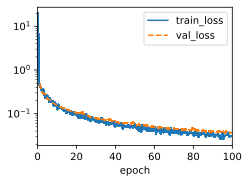

In [12]:
trainer = Trainer(max_epochs=100)
models = k_fold(trainer, data, k=5, lr=0.01)

### 5.7.8. Submitting Predictions on Kaggle

In [13]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)